# Descarga datos

In [ ]:
import requests
from pandas.io.json import json_normalize
import pandas as pd

url="https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=1000000000"
Datos=pd.read_json(url,convert_dates=['fecha_de_notificaci_n','fecha_de_muerte','fis','fecha_diagnostico','fecha_recuperado','fecha_reporte_web'])

In [ ]:
Datos.rename(columns={'id_de_caso':'id_caso','fecha_de_notificaci_n':'fecha_notificacion','c_digo_divipola':'codigo_municipio','ciudad_de_ubicaci_n':'ciudad',
                      'atenci_n':'atencion','tipo':'tipo_contagio','estado':'estado','pa_s_de_procedencia':'pais_procedencia','fis':'fecha_sintomas',
                      'tipo_recuperaci_n':'tipo_recuperacion','fecha_de_muerte':'fecha_muerte'},inplace=True)

In [ ]:
Datos

,id_caso,fecha_notificacion,codigo_municipio,ciudad,departamento,atencion,edad,sexo,tipo_contagio,estado,pais_procedencia,fecha_sintomas,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_muerte
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06,2020-03-13,2020-03-06,PCR,11,380.0,Otro,NaN,NaT
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,2020-03-09,2020-03-19,2020-03-09,PCR,76,724.0,Otro,NaN,NaT
2,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,2020-03-09,2020-03-15,2020-03-09,PCR,5,724.0,Otro,NaN,NaT
3,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,2020-03-11,2020-03-26,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
4,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,2020-03-11,2020-03-23,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650057,650098,2020-08-23,5147,Carepa,Antioquia,Casa,39,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
650058,650099,2020-08-23,5266,Envigado,Antioquia,Casa,40,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
650059,650100,2020-08-23,5360,Itagüí,Antioquia,Casa,58,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
650060,650101,2020-08-23,5360,Itagüí,Antioquia,Casa,78,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT


# Análisis datos y dataset final para modelar

In [ ]:
# Cuenta vacíos
Datos.isna().sum()

id_caso                     0
fecha_notificacion          0
codigo_municipio            0
ciudad                      0
departamento                0
atencion                    0
edad                        0
sexo                        0
tipo_contagio               0
estado                      0
pais_procedencia       649097
fecha_sintomas              0
fecha_diagnostico        3976
fecha_recuperado       151836
fecha_reporte_web           0
tipo_recuperacion      151841
codigo_departamento         0
codigo_pais            649101
pertenencia_etnica     366607
nombre_grupo_etnico    638737
fecha_muerte           627849
dtype: int64

In [ ]:
# 5 principales ciudades: Bogotá, Medellín, Cali, Barranquilla y Cartagena de Indias, coincide con las de más casos
Datos['ciudad'].value_counts().head(10)

Bogotá D.C.            221738
Medellín                49932
Cali                    38466
Barranquilla            36520
Cartagena de Indias     20758
Soledad                 13922
Montería                12613
Valledupar               9127
Bucaramanga              9047
Soacha                   8941
Name: ciudad, dtype: int64

In [ ]:
# filtrando ciudades
Datos1=Datos[Datos['ciudad'].isin(['Medellín'])]
Datos1.reset_index(inplace=True,drop=True)
Datos1

,id_caso,fecha_notificacion,codigo_municipio,ciudad,departamento,atencion,edad,sexo,tipo_contagio,estado,pais_procedencia,fecha_sintomas,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_muerte
0,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,2020-03-09,2020-03-15,2020-03-09,PCR,5,724.0,Otro,NaN,NaT
1,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,2020-03-11,2020-03-26,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
2,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,2020-03-11,2020-03-23,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
3,20,2020-03-11,5001,Medellín,Antioquia,Recuperado,26,F,Relacionado,Leve,NaN,2020-03-09T00:00:00.000,2020-03-14,2020-03-24,2020-03-14,PCR,5,NaN,Otro,NaN,NaT
4,21,2020-03-11,5001,Medellín,Antioquia,Recuperado,28,M,Relacionado,Leve,NaN,2020-03-10T00:00:00.000,2020-03-14,2020-04-10,2020-03-14,PCR,5,NaN,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49927,649843,2020-08-23,5001,Medellín,Antioquia,Casa,46,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
49928,649844,2020-08-23,5001,Medellín,Antioquia,Casa,47,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
49929,649846,2020-08-23,5001,Medellín,Antioquia,Casa,38,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
49930,649847,2020-08-23,5001,Medellín,Antioquia,Casa,35,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT


# **Metodologías propuestas y desarrollo de los modelos**

## Metodología 1: Nuevos ARIMA Y POLINOMIAL CON ERORRES ARIMA

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

In [ ]:
tabla_nuevos

,fecha_reporte_web,casos_nuevos_reportados,casos_confirmados
0,2020-03-09,1,1
1,2020-03-11,2,3
2,2020-03-14,2,5
3,2020-03-15,1,6
4,2020-03-19,3,9
...,...,...,...
165,2020-08-31,923,47328
166,2020-09-01,633,47961
167,2020-09-02,732,48693
168,2020-09-03,282,48975


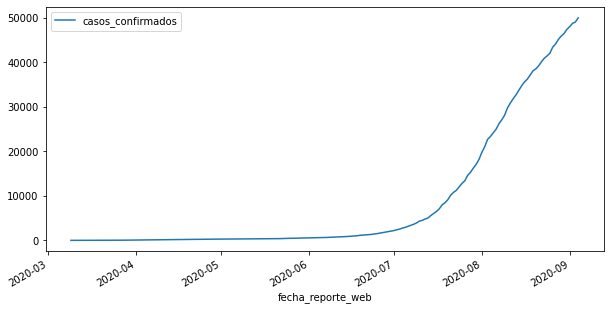

In [ ]:
# los casos confirmados no pueden ser con modelo basado en la tendencia, se tiene que predecir con el resultado de la suma de los casos nuevos reportados
tabla_nuevos.plot(x='fecha_reporte_web',y='casos_confirmados',figsize=(10, 5)).figure.savefig('1.png')

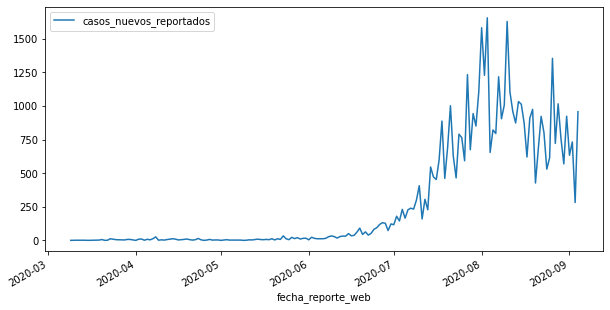

In [ ]:
tabla_nuevos.plot(x='fecha_reporte_web',y='casos_nuevos_reportados',figsize=(10, 5)).figure.savefig('2.png')

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


mean1=8.905882, mean2=578.529412
variance1=57.214671, variance2=178002.907958


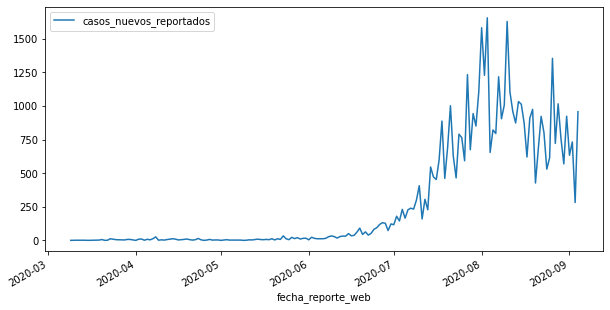

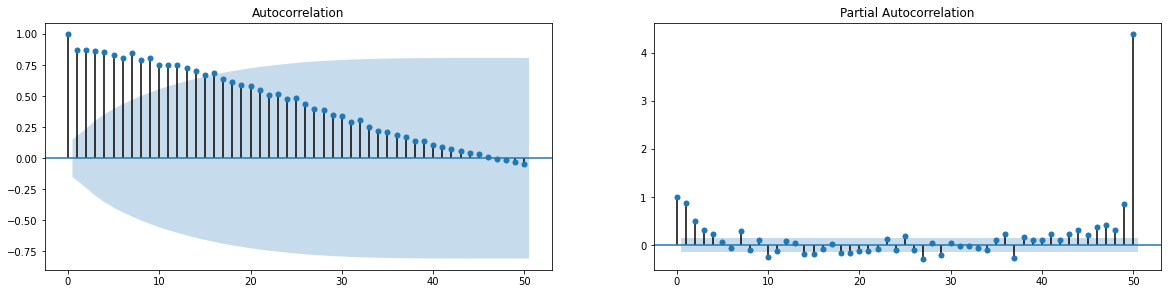

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M1Nuevos=M1Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)
M1Nuevos.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Nuevos.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Nuevos, lags=50, ax=ax2)

X=M1Nuevos.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


mean1=1.823188, mean2=5.908150
variance1=0.814138, variance2=1.280764


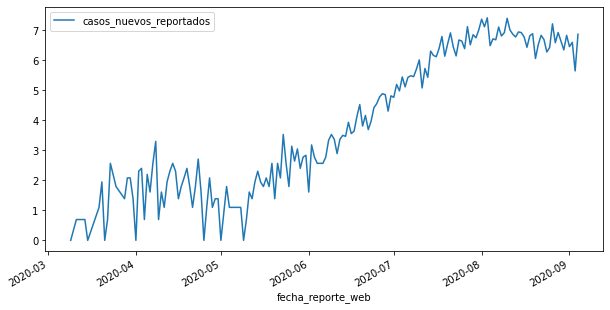

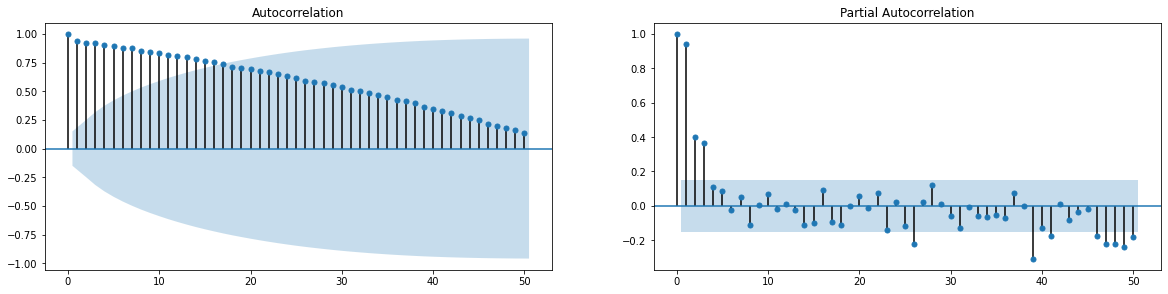

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1NuevosLog=np.log(M1Nuevos)
plt.rcParams["figure.figsize"] = (10,5)
M1NuevosLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1NuevosLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1NuevosLog, lags=50, ax=ax2)

X=M1NuevosLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

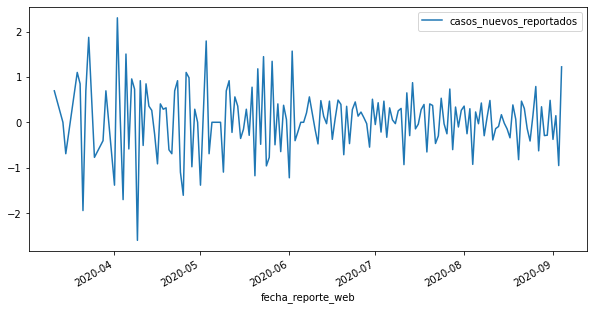

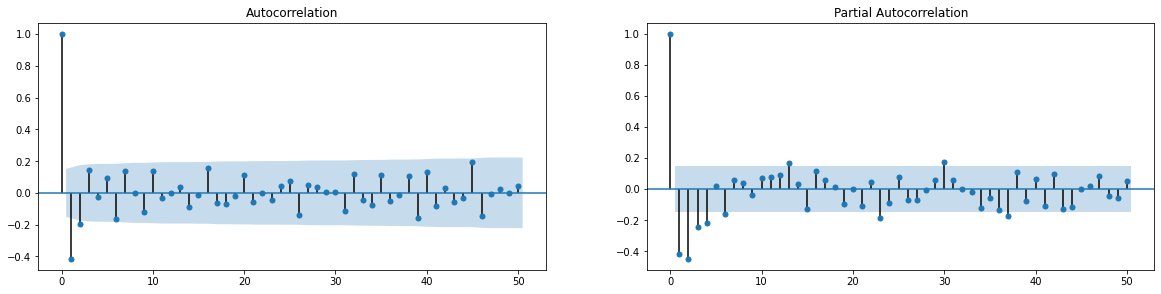

In [ ]:
# Primera diferencia para volver estacional
M1NuevosLogDif=M1NuevosLog.diff()
M1NuevosLogDif=M1NuevosLogDif[1:]
M1NuevosLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1NuevosLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1NuevosLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1NuevosLogTrain=M1NuevosLog[:int(len(M1NuevosLog)*p_train)]
M1NuevosLogTest=M1NuevosLog[int(len(M1NuevosLog)*p_train):int(len(M1NuevosLog)*(p_train+p_test))]
M1NuevosLogForecast=M1NuevosLog[int(len(M1NuevosLog)*(p_train+p_test)):]
print(M1NuevosLog.shape)
print(M1NuevosLogTrain.shape)
print(M1NuevosLogTest.shape)
print(M1NuevosLogForecast.shape)

(170, 1)
(136, 1)
(20, 1)
(14, 1)


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 6.1MB/s 
     |████████████████████████████████| 2.1MB 43.7MB/s 
     |████████████████████████████████| 8.7MB 46.7MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1NuevosLogTrain)
arima.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  (params_trend, params_ar, params_ma,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  )


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  136
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -118.681
Date:                Sat, 05 Sep 2020   AIC                            247.362
Time:                        18:34:27   BIC                            261.888
Sample:                             0   HQIC                           253.265
                                - 136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0719      0.023      3.079      0.002       0.026       0.118
ar.L1         -0.1741      0.128     -1.361      0.173      -0.425       0.077
ar.L2         -0.2883      0.079     -3.656      0.000      -0.443      -0.134
ma.L1         -0.6078      0.120     -5.084      0.000      -0.842      -0.373
sigma2         0.3371      0.036      9.325      0.000       0.266       0.408
===================================================================================
Ljung-Box (Q):                       33.40   Jarque-Bera (JB):                18.84
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


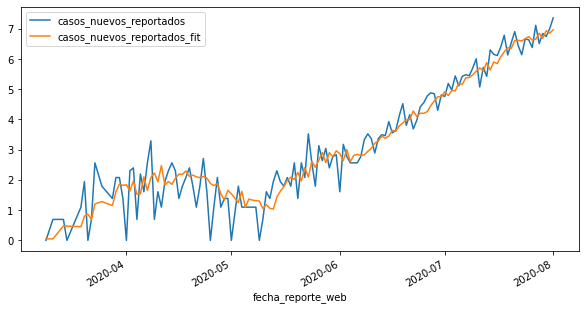

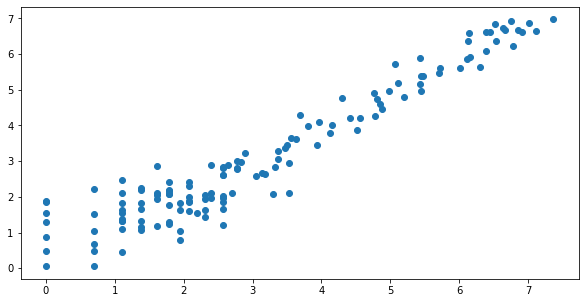

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


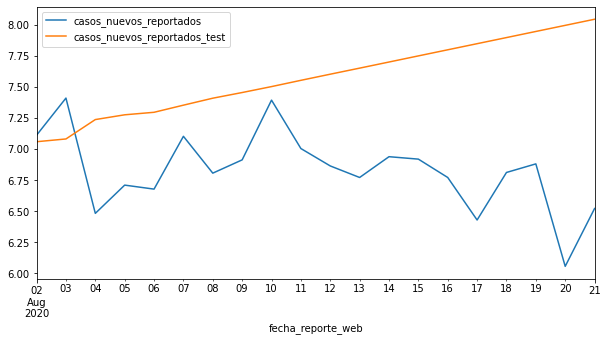

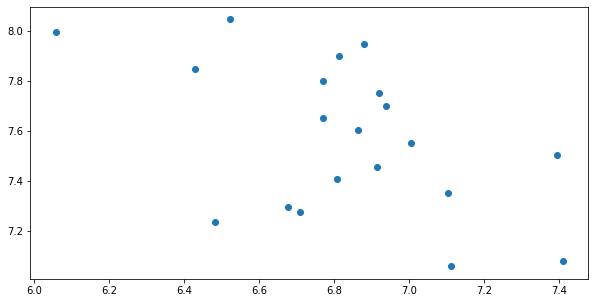

In [ ]:
M1NuevosLogTrain['casos_nuevos_reportados_fit']=arima.predict_in_sample()
plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5)).figure.savefig('3.png')

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])
plt.savefig('4.png')
plt.show()


M1NuevosLogTest['casos_nuevos_reportados_test']=arima.predict(n_periods=(len(M1NuevosLogTest)))
plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10,5)).figure.savefig('5.png')

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_test'])
plt.savefig('6.png')
plt.show()

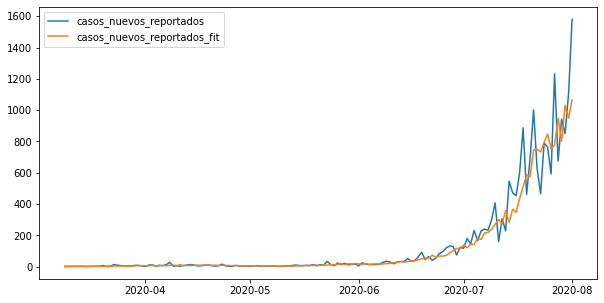

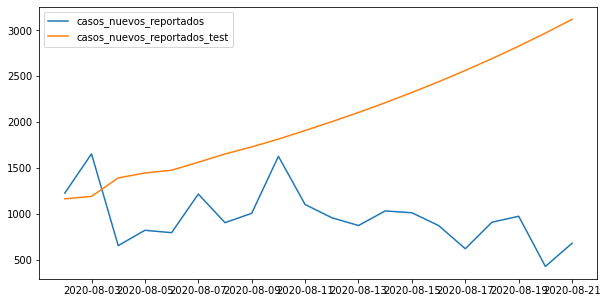

In [ ]:
FM1Nuevos=np.exp(M1NuevosLogTrain)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_fit'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_fit'])
plt.savefig('7.png')
plt.show()

FM1NuevosTest=np.exp(M1NuevosLogTest)
plt.plot(FM1NuevosTest['casos_nuevos_reportados'])
plt.plot(FM1NuevosTest['casos_nuevos_reportados_test'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_test'])
plt.savefig('8.png')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Nuevos['casos_nuevos_reportados'],FM1Nuevos['casos_nuevos_reportados_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1NuevosTest['casos_nuevos_reportados'],FM1NuevosTest['casos_nuevos_reportados_test'])
print('MSE in test: %f' % msetest)

MSE in train: 8747.292937
MSE in test: 1724364.338412


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1NuevosLogTrain=M1NuevosLog[:int(len(M1NuevosLog)*p_train)]
M1NuevosLogTest=M1NuevosLog[int(len(M1NuevosLog)*p_train):int(len(M1NuevosLog)*(p_train+p_test))]
M1NuevosLogForecast=M1NuevosLog[int(len(M1NuevosLog)*(p_train+p_test)):]
print(M1NuevosLog.shape)
print(M1NuevosLogTrain.shape)
print(M1NuevosLogTest.shape)
print(M1NuevosLogForecast.shape)

(169, 1)
(135, 1)
(20, 1)
(14, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


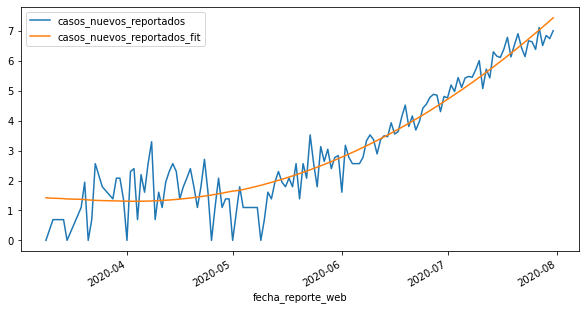

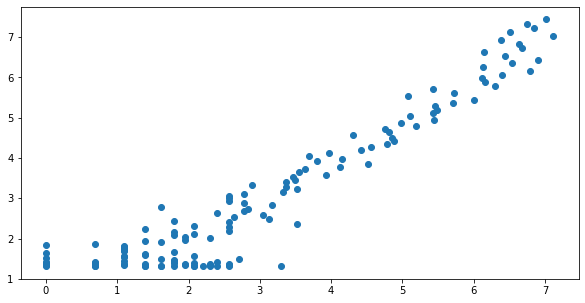

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


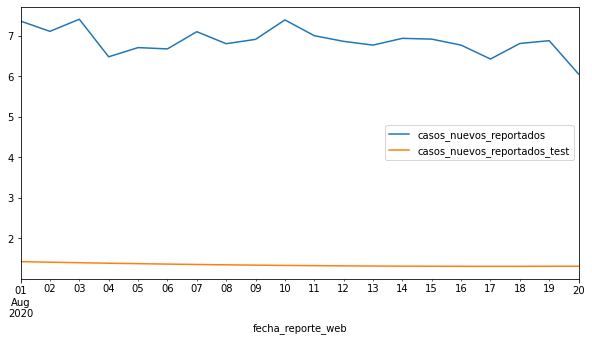

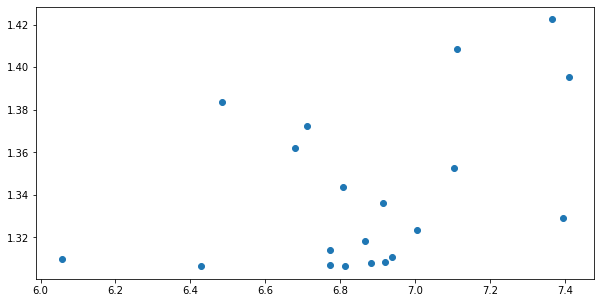

Mean squared error: 0.40
Variance score: 0.90


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1NuevosLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1NuevosLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=2)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1NuevosLogTrain['casos_nuevos_reportados'].values.reshape(-1,1))
M1NuevosLogTrain['casos_nuevos_reportados_fit']=model.predict(x_trainpoly)

plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])
plt.show()

M1NuevosLogTest['casos_nuevos_reportados_test']=model.predict(x_testpoly)
plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])))

print('Variance score: %.2f' % r2_score(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit']))

# LinnearRegression() 0.4, 0.89

In [ ]:
x_trainpoly

array([[1.0000e+00, 0.0000e+00, 0.0000e+00],
       [1.0000e+00, 1.0000e+00, 1.0000e+00],
       [1.0000e+00, 2.0000e+00, 4.0000e+00],
       [1.0000e+00, 3.0000e+00, 9.0000e+00],
       [1.0000e+00, 4.0000e+00, 1.6000e+01],
       [1.0000e+00, 5.0000e+00, 2.5000e+01],
       [1.0000e+00, 6.0000e+00, 3.6000e+01],
       [1.0000e+00, 7.0000e+00, 4.9000e+01],
       [1.0000e+00, 8.0000e+00, 6.4000e+01],
       [1.0000e+00, 9.0000e+00, 8.1000e+01],
       [1.0000e+00, 1.0000e+01, 1.0000e+02],
       [1.0000e+00, 1.1000e+01, 1.2100e+02],
       [1.0000e+00, 1.2000e+01, 1.4400e+02],
       [1.0000e+00, 1.3000e+01, 1.6900e+02],
       [1.0000e+00, 1.4000e+01, 1.9600e+02],
       [1.0000e+00, 1.5000e+01, 2.2500e+02],
       [1.0000e+00, 1.6000e+01, 2.5600e+02],
       [1.0000e+00, 1.7000e+01, 2.8900e+02],
       [1.0000e+00, 1.8000e+01, 3.2400e+02],
       [1.0000e+00, 1.9000e+01, 3.6100e+02],
       [1.0000e+00, 2.0000e+01, 4.0000e+02],
       [1.0000e+00, 2.1000e+01, 4.4100e+02],
       [1.

In [ ]:
M1NuevosLogTrain['Errores']=M1NuevosLogTrain['casos_nuevos_reportados']-M1NuevosLogTrain['casos_nuevos_reportados_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1NuevosLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  (params_trend, params_ar, params_ma,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  )
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  
/usr/local/lib/python3.6/dis

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  135
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -116.648
Date:                Fri, 04 Sep 2020   AIC                            243.296
Time:                        05:47:25   BIC                            257.822
Sample:                             0   HQIC                           249.199
                                - 135                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7052      0.188      3.758      0.000       0.337       1.073
ar.L2         -0.1134      0.118     -0.960      0.337      -0.345       0.118
ar.L3          0.2607      0.083      3.152      0.002       0.099       0.423
ma.L1         -0.5277      0.185     -2.850      0.004      -0.891      -0.165
sigma2         0.3283      0.036      9.243      0.000       0.259       0.398
===================================================================================
Ljung-Box (Q):                       33.33   Jarque-Bera (JB):                 4.18
Prob(Q):                              0.76   Prob(JB):                         0.12
Heteroskedasticity (H):               0.18   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


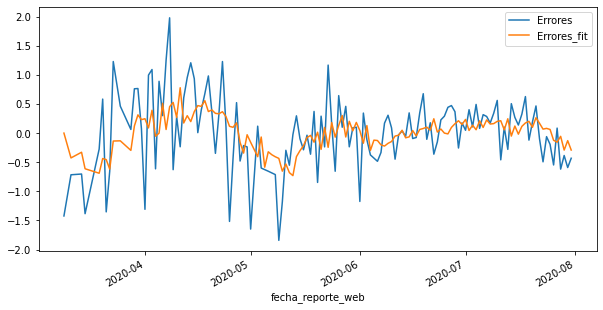

In [ ]:
M1NuevosLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1NuevosLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


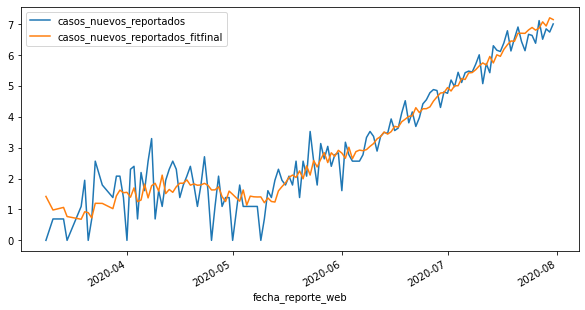

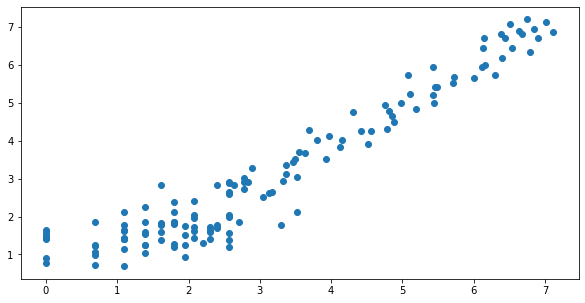

In [ ]:
M1NuevosLogTrain['casos_nuevos_reportados_fitfinal']=M1NuevosLogTrain['casos_nuevos_reportados_fit']+M1NuevosLogTrain['Errores_fit']
plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


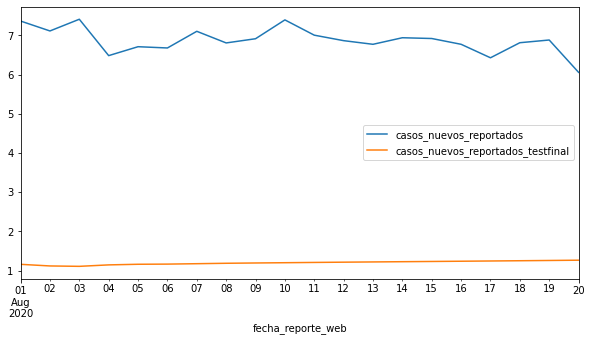

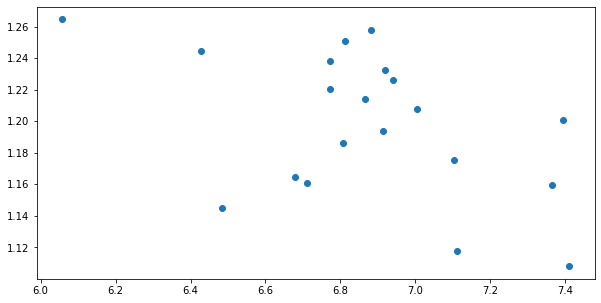

In [ ]:
M1NuevosLogTest['Errores_test']=arima.predict(n_periods=(len(M1NuevosLogTest)))
M1NuevosLogTest['casos_nuevos_reportados_testfinal']=M1NuevosLogTest['casos_nuevos_reportados_test']+M1NuevosLogTest['Errores_test']

plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_testfinal'])
plt.show() 

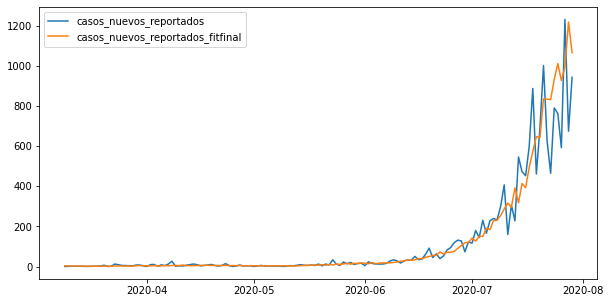

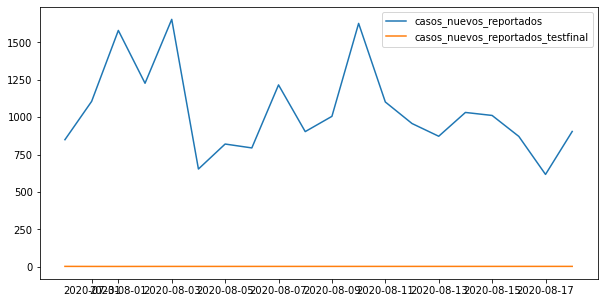

In [ ]:
FM1Nuevos=np.exp(M1NuevosLogTrain)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_fitfinal'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_fitfinal'])
plt.show()

FM1NuevosTest=np.exp(M1NuevosLogTest)
plt.plot(FM1NuevosTest['casos_nuevos_reportados'])
plt.plot(FM1NuevosTest['casos_nuevos_reportados_testfinal'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_testfinal'])
plt.show()

#x_fore=M1NuevosLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 1: Muerte ARIMA Y POLINOMIAL CON ERORRES ARIMA



In [ ]:
# tabla con ciudades filtradas para modelar casos fallecidos
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muerte'},inplace=True)

In [ ]:
tabla_muerte

,fecha_muerte,casos_muerte
0,2020-04-03,1
1,2020-04-18,1
2,2020-04-27,1
3,2020-06-05,1
4,2020-06-14,1
...,...,...
74,2020-08-30,18
75,2020-08-31,19
76,2020-09-01,12
77,2020-09-02,13


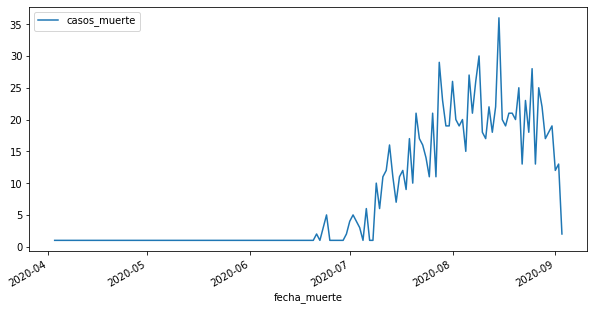

In [ ]:
tabla_muerte.plot(x='fecha_muerte',y='casos_muerte',figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


mean1=6.925000, mean2=20.179487
variance1=38.419375, variance2=35.480605


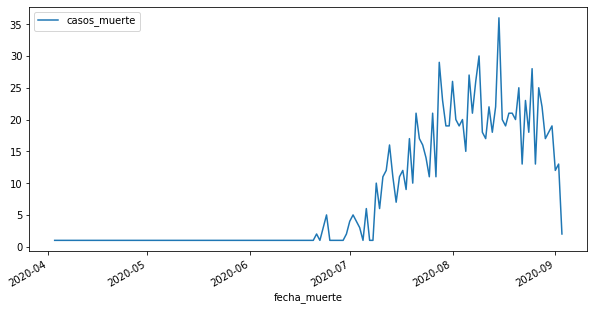

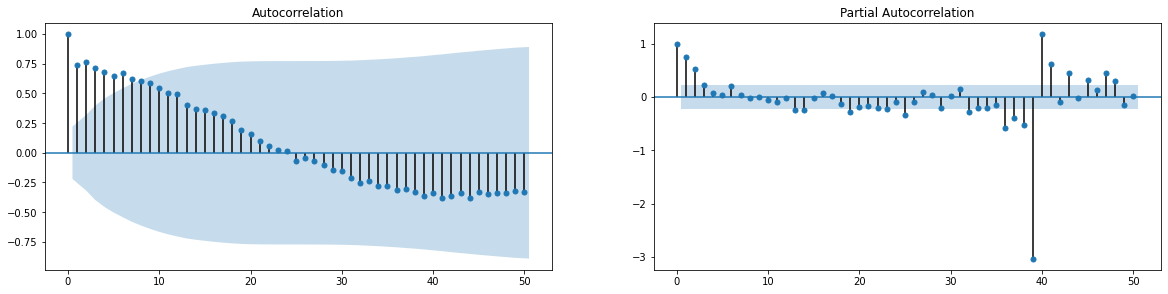

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)
M1Muerte.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Muerte.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Muerte, lags=50, ax=ax2)

X=M1Muerte.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


mean1=1.382732, mean2=2.936502
variance1=1.315844, variance2=0.197314


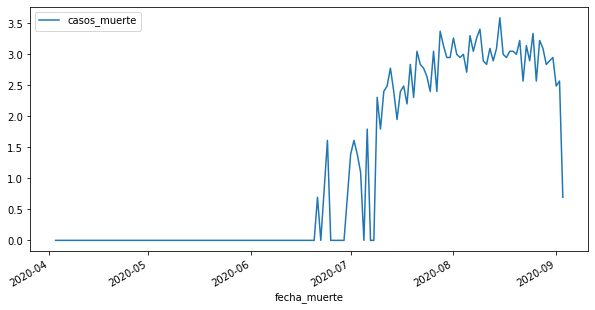

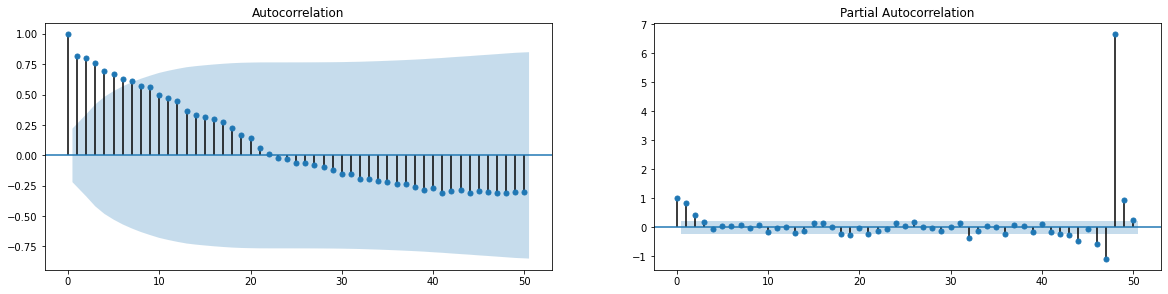

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1MuerteLog=np.log(M1Muerte)
plt.rcParams["figure.figsize"] = (10,5)
M1MuerteLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1MuerteLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1MuerteLog, lags=50, ax=ax2)

X=M1MuerteLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

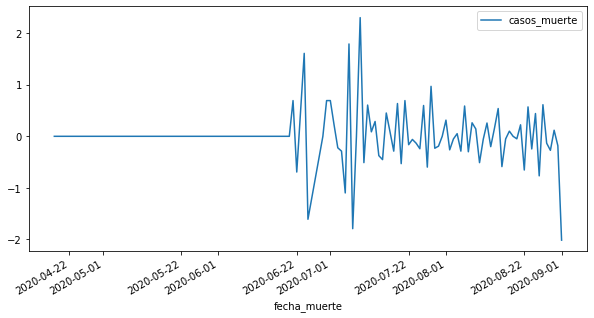

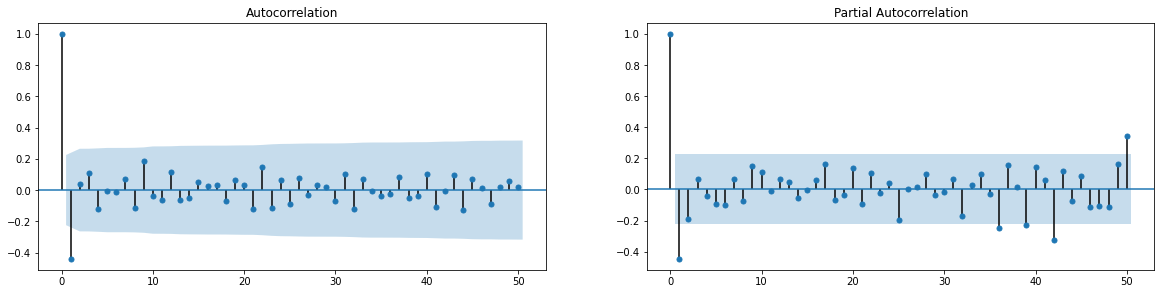

In [ ]:
# Primera diferencia para volver estacional
M1MuerteLogDif=M1MuerteLog.diff()
M1MuerteLogDif=M1MuerteLogDif[1:]
M1MuerteLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1MuerteLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1MuerteLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1MuerteLogTrain=M1MuerteLog[:int(len(M1MuerteLog)*p_train)]
M1MuerteLogTest=M1MuerteLog[int(len(M1MuerteLog)*p_train):int(len(M1MuerteLog)*(p_train+p_test))]
M1MuerteLogForecast=M1MuerteLog[int(len(M1MuerteLog)*(p_train+p_test)):]
print(M1MuerteLog.shape)
print(M1MuerteLogTrain.shape)
print(M1MuerteLogTest.shape)
print(M1MuerteLogForecast.shape)

(77, 1)
(61, 1)
(9, 1)
(7, 1)


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1MuerteLogTrain)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -47.438
Date:                Wed, 02 Sep 2020   AIC                            100.876
Time:                        18:05:32   BIC                            107.159
Sample:                             0   HQIC                           103.334
                                 - 61                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0564      0.018      3.144      0.002       0.021       0.092
ma.L1         -0.7480      0.077     -9.693      0.000      -0.899      -0.597
sigma2         0.2807      0.049      5.685      0.000       0.184       0.378
===================================================================================
Ljung-Box (Q):                       26.99   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.94   Prob(JB):                         0.30
Heteroskedasticity (H):               0.23   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


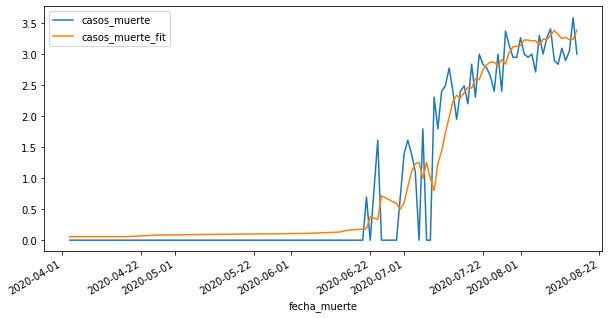

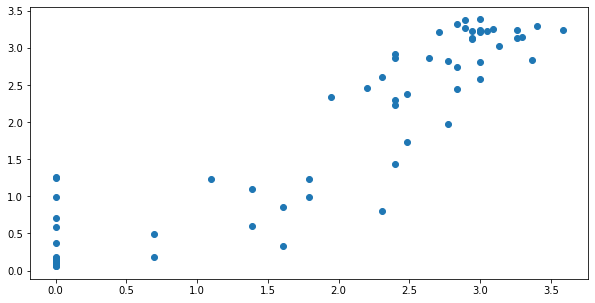

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


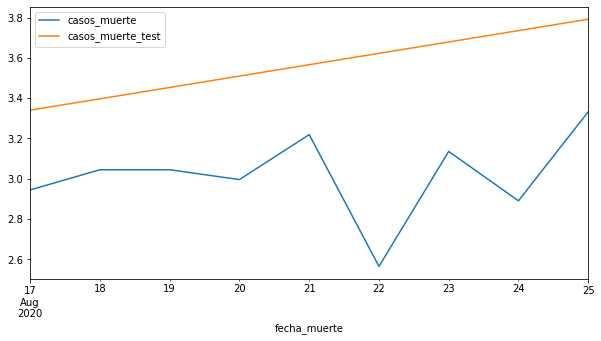

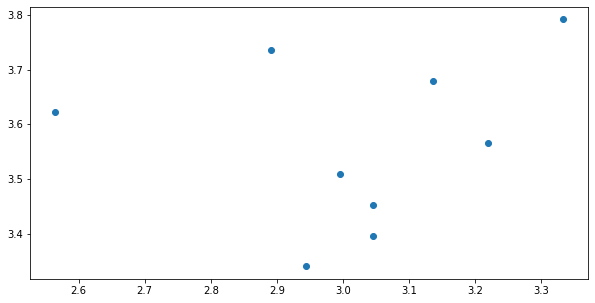

In [ ]:
M1MuerteLogTrain['casos_muerte_fit']=arima.predict_in_sample()
plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])
plt.show()

M1MuerteLogTest['casos_muerte_test']=arima.predict(n_periods=(len(M1MuerteLogTest))) 
plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_test'])
plt.show()

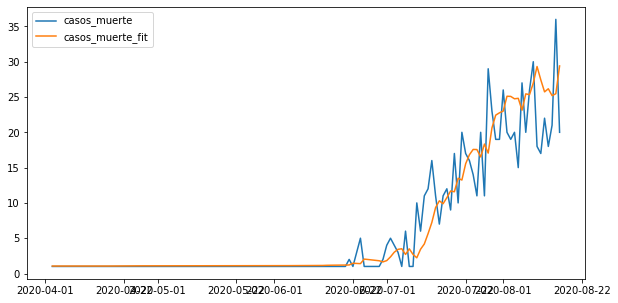

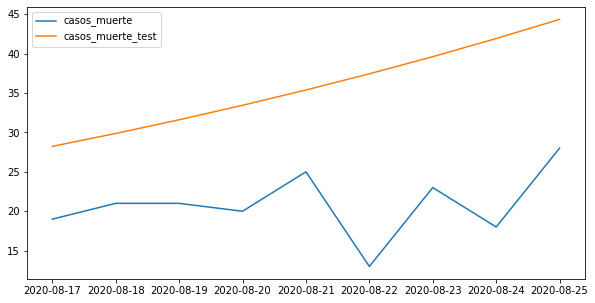

In [ ]:
FM1Muerte=np.exp(M1MuerteLogTrain)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_fit'])
plt.legend(['casos_muerte','casos_muerte_fit'])
plt.show()

FM1MuerteTest=np.exp(M1MuerteLogTest)
plt.plot(FM1MuerteTest['casos_muerte'])
plt.plot(FM1MuerteTest['casos_muerte_test'])
plt.legend(['casos_muerte','casos_muerte_test'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Muerte['casos_muerte'],FM1Muerte['casos_muerte_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1MuerteTest['casos_muerte'],FM1MuerteTest['casos_muerte_test'])
print('MSE in test: %f' % msetest)

MSE in train: 24.185961
MSE in test: 252.727195


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1MuerteLogTrain=M1MuerteLog[:int(len(M1MuerteLog)*p_train)]
M1MuerteLogTest=M1MuerteLog[int(len(M1MuerteLog)*p_train):int(len(M1MuerteLog)*(p_train+p_test))]
M1MuerteLogForecast=M1MuerteLog[int(len(M1MuerteLog)*(p_train+p_test)):]
print(M1MuerteLog.shape)
print(M1MuerteLogTrain.shape)
print(M1MuerteLogTest.shape)
print(M1MuerteLogForecast.shape)

(74, 1)
(59, 1)
(9, 1)
(6, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


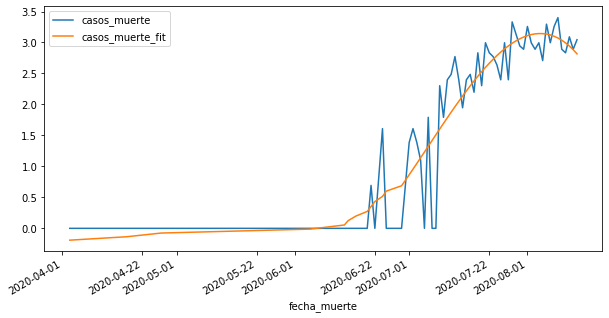

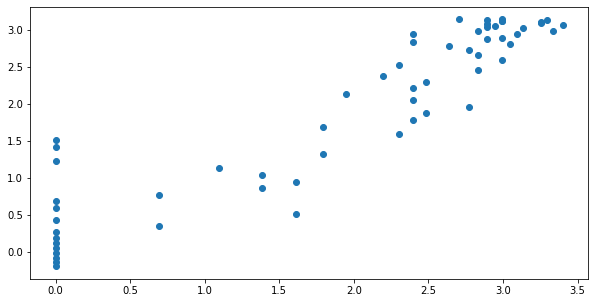

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


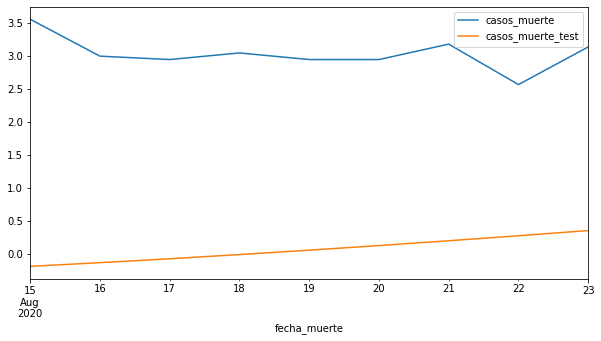

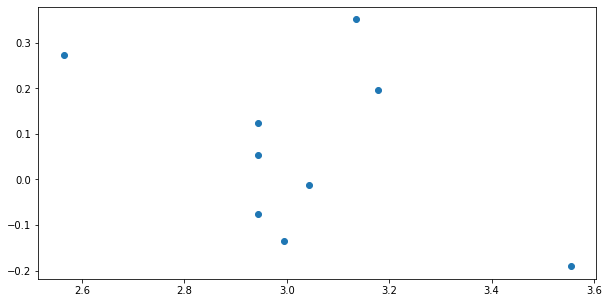

Mean squared error: 0.22
Variance score: 0.85


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1MuerteLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1MuerteLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=3)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1MuerteLogTrain['casos_muerte'].values.reshape(-1,1))
M1MuerteLogTrain['casos_muerte_fit']=model.predict(x_trainpoly)

plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])
plt.show()

M1MuerteLogTest['casos_muerte_test']=model.predict(x_testpoly)
plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])))

print('Variance score: %.2f' % r2_score(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit']))

#3
#Mean squared error: 0.11
#Variance score: 0.94

# LinnearRegression()

In [ ]:
M1MuerteLogTrain['Errores']=M1MuerteLogTrain['casos_muerte']-M1MuerteLogTrain['casos_muerte_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1MuerteLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.enforce_stationarity and
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:                        SARIMAX   Log Likelihood                 -39.631
Date:                Tue, 01 Sep 2020   AIC                             81.262
Time:                        02:33:05   BIC                             83.339
Sample:                             0   HQIC                            82.073
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2244      0.029      7.706      0.000       0.167       0.281
===================================================================================
Ljung-Box (Q):                       24.05   Jarque-Bera (JB):                18.17
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


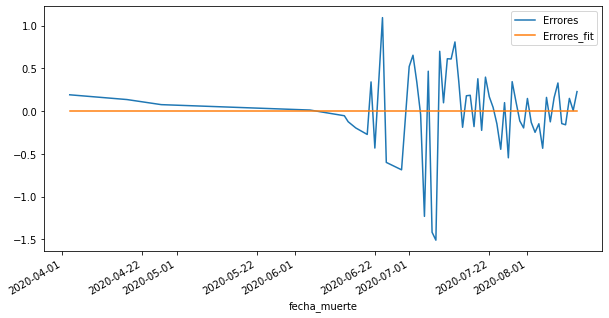

In [ ]:
M1MuerteLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1MuerteLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


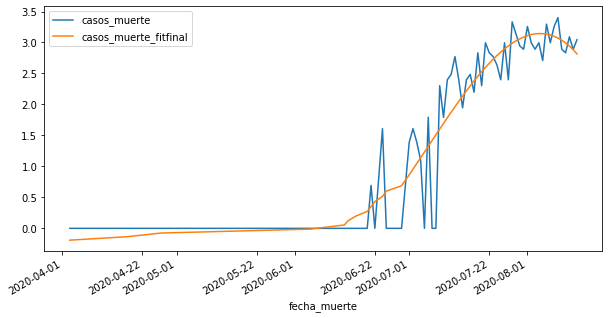

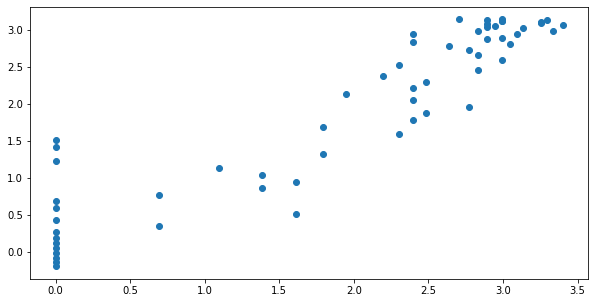

In [ ]:
M1MuerteLogTrain['casos_muerte_fitfinal']=M1MuerteLogTrain['casos_muerte_fit']+M1MuerteLogTrain['Errores_fit']
plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


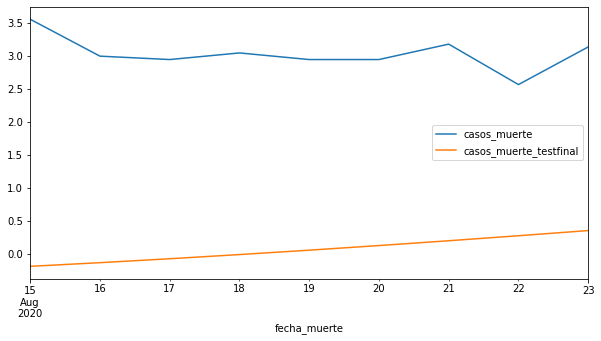

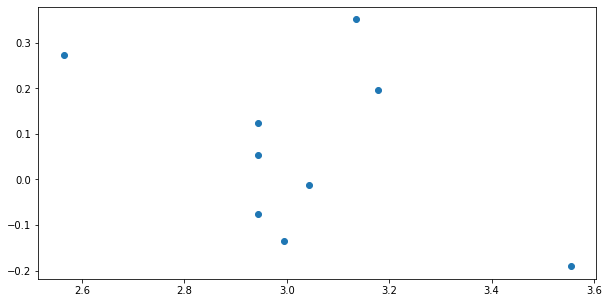

In [ ]:
M1MuerteLogTest['Errores_test']=arima.predict(n_periods=(len(M1MuerteLogTest)))
M1MuerteLogTest['casos_muerte_testfinal']=M1MuerteLogTest['casos_muerte_test']+M1MuerteLogTest['Errores_test']

plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_testfinal'])
plt.show() 

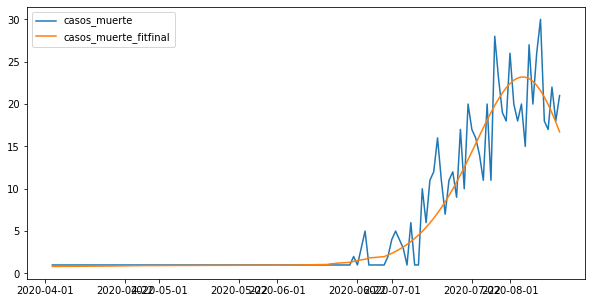

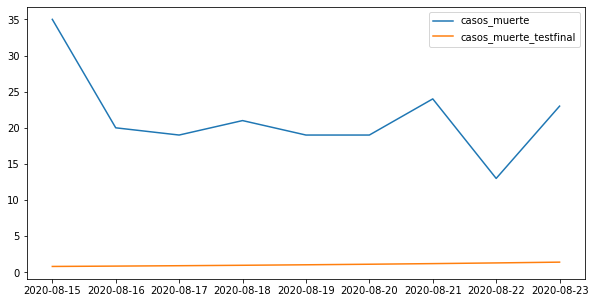

In [ ]:
FM1Muerte=np.exp(M1MuerteLogTrain)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_fitfinal'])
plt.legend(['casos_muerte','casos_muerte_fitfinal'])
plt.show()

FM1Muerte=np.exp(M1MuerteLogTest)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_testfinal'])
plt.legend(['casos_muerte','casos_muerte_testfinal'])
plt.show()

#x_fore=M1MuerteLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 1: Recuperado ARIMA Y POLINOMIAL CON ERORRES ARIMA

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperados
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

In [ ]:
tabla_recuperado

,fecha_recuperado,casos_recuperado
0,2020-03-15,1
1,2020-03-23,2
2,2020-03-24,1
3,2020-03-25,2
4,2020-03-26,2
...,...,...
155,2020-08-28,694
156,2020-08-29,907
157,2020-08-30,923
158,2020-08-31,823


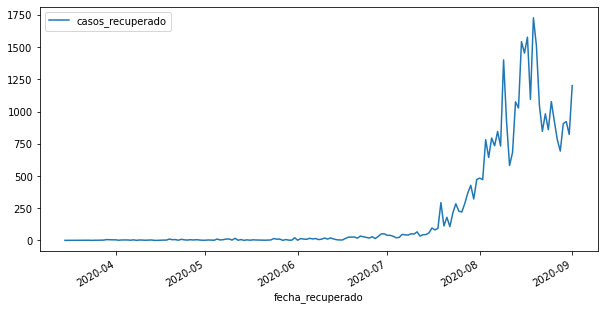

In [ ]:
tabla_recuperado.plot(x='fecha_recuperado',y='casos_recuperado',figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


mean1=6.062500, mean2=450.262500
variance1=24.283594, variance2=232316.243594


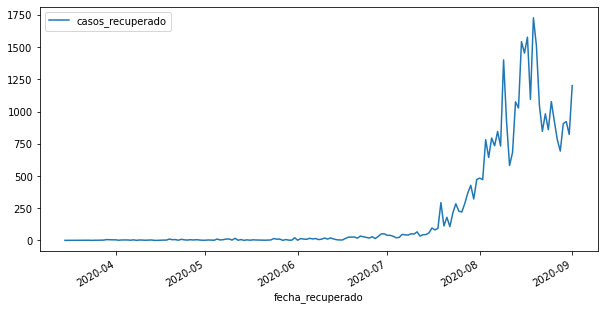

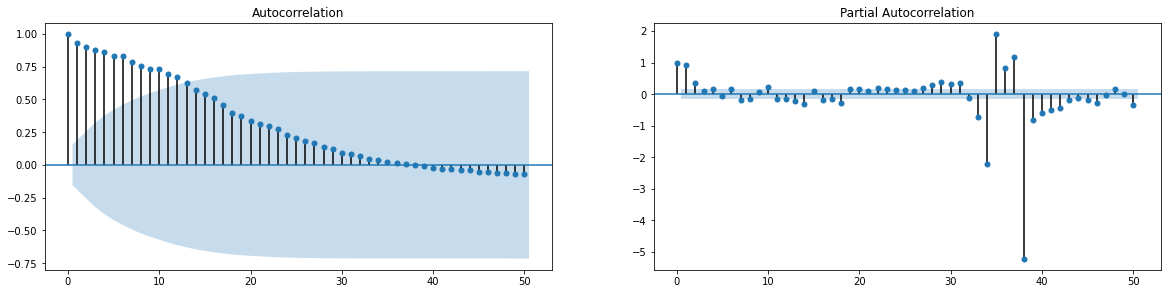

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)
M1Recuperado.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Recuperado.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Recuperado, lags=50, ax=ax2)

X=M1Recuperado.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1.482432, mean2=5.125234
variance1=0.667321, variance2=2.768317


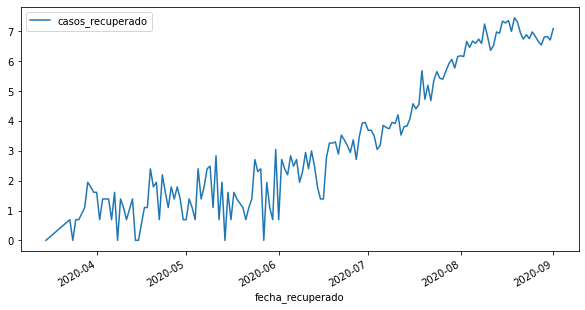

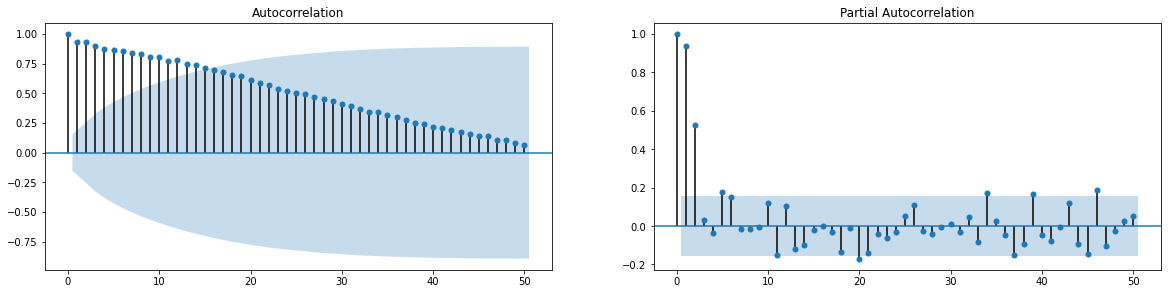

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1RecuperadoLog=np.log(M1Recuperado)
plt.rcParams["figure.figsize"] = (10,5)
M1RecuperadoLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1RecuperadoLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1RecuperadoLog, lags=50, ax=ax2)

X=M1RecuperadoLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

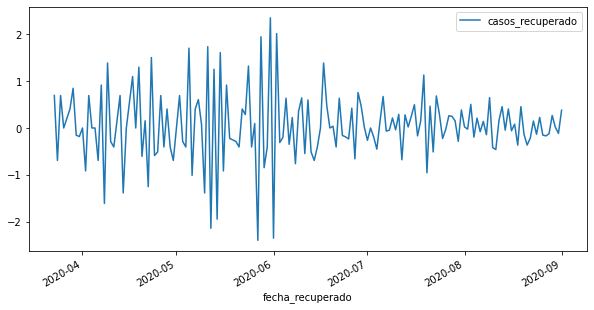

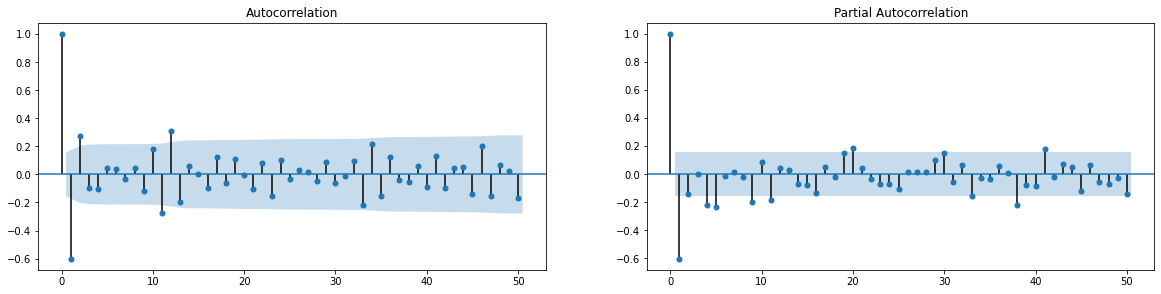

In [ ]:
# Primera diferencia para volver estacional
M1RecuperadoLogDif=M1RecuperadoLog.diff()
M1RecuperadoLogDif=M1RecuperadoLogDif[1:]
M1RecuperadoLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1RecuperadoLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1RecuperadoLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1RecuperadoLogTrain=M1RecuperadoLog[:int(len(M1RecuperadoLog)*p_train)]
M1RecuperadoLogTest=M1RecuperadoLog[int(len(M1RecuperadoLog)*p_train):int(len(M1RecuperadoLog)*(p_train+p_test))]
M1RecuperadoLogForecast=M1RecuperadoLog[int(len(M1RecuperadoLog)*(p_train+p_test)):]
print(M1RecuperadoLog.shape)
print(M1RecuperadoLogTrain.shape)
print(M1RecuperadoLogTest.shape)
print(M1RecuperadoLogForecast.shape)

(160, 1)
(128, 1)
(19, 1)
(13, 1)


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1RecuperadoLogTrain)
arima.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.enforce_stationarity and


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  128
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -117.261
Date:                Wed, 02 Sep 2020   AIC                            244.523
Time:                        18:07:47   BIC                            258.744
Sample:                             0   HQIC                           250.301
                                - 128                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0406      0.014      2.910      0.004       0.013       0.068
ma.L1         -0.7969      0.076    -10.501      0.000      -0.946      -0.648
ma.L2          0.4140      0.108      3.827      0.000       0.202       0.626
ma.L3         -0.4102      0.080     -5.117      0.000      -0.567      -0.253
sigma2         0.3676      0.044      8.379      0.000       0.282       0.454
===================================================================================
Ljung-Box (Q):                       34.81   Jarque-Bera (JB):                 8.29
Prob(Q):                              0.70   Prob(JB):                         0.02
Heteroskedasticity (H):               0.46   Skew:                            -0.54
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


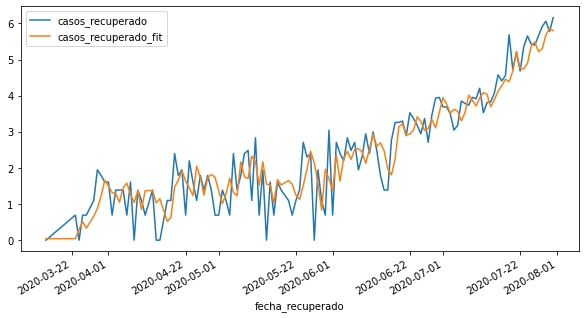

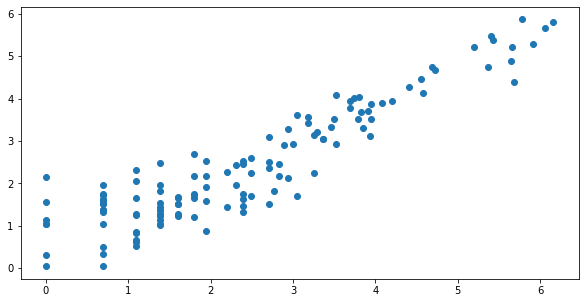

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


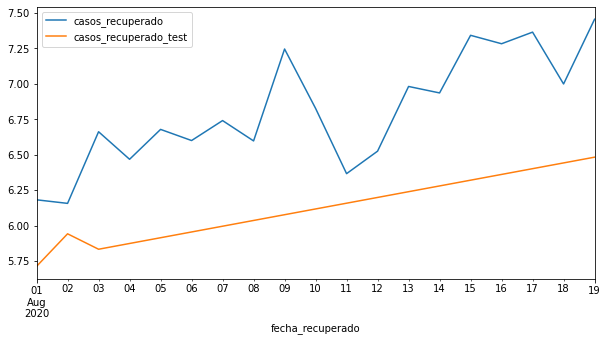

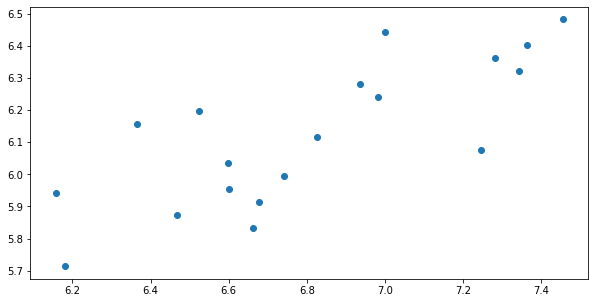

In [ ]:
M1RecuperadoLogTrain['casos_recuperado_fit']=arima.predict_in_sample()
plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])
plt.show()



M1RecuperadoLogTest['casos_recuperado_test']=arima.predict(n_periods=(len(M1RecuperadoLogTest))) 
plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_test'])
plt.show()

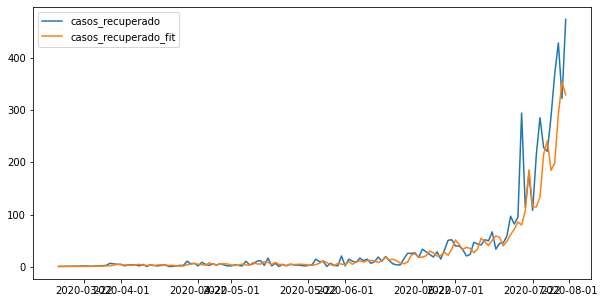

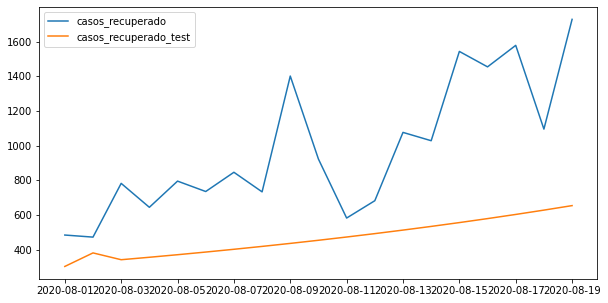

In [ ]:
FM1Recuperado=np.exp(M1RecuperadoLogTrain)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_fit'])
plt.legend(['casos_recuperado','casos_recuperado_fit'])
plt.show()

FM1RecuperadoTest=np.exp(M1RecuperadoLogTest)
plt.plot(FM1RecuperadoTest['casos_recuperado'])
plt.plot(FM1RecuperadoTest['casos_recuperado_test'])
plt.legend(['casos_recuperado','casos_recuperado_test'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Recuperado['casos_recuperado'],FM1Recuperado['casos_recuperado_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1RecuperadoTest['casos_recuperado'],FM1RecuperadoTest['casos_recuperado_test'])
print('MSE in test: %f' % msetest)

MSE in train: 1299.431317
MSE in test: 354801.092240


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1RecuperadoLogTrain=M1RecuperadoLog[:int(len(M1RecuperadoLog)*p_train)]
M1RecuperadoLogTest=M1RecuperadoLog[int(len(M1RecuperadoLog)*p_train):int(len(M1RecuperadoLog)*(p_train+p_test))]
M1RecuperadoLogForecast=M1RecuperadoLog[int(len(M1RecuperadoLog)*(p_train+p_test)):]
print(M1RecuperadoLog.shape)
print(M1RecuperadoLogTrain.shape)
print(M1RecuperadoLogTest.shape)
print(M1RecuperadoLogForecast.shape)

(158, 1)
(126, 1)
(19, 1)
(13, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


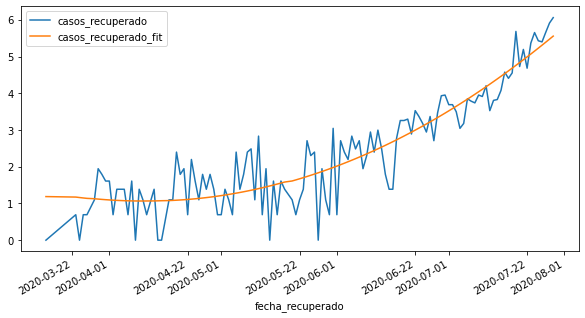

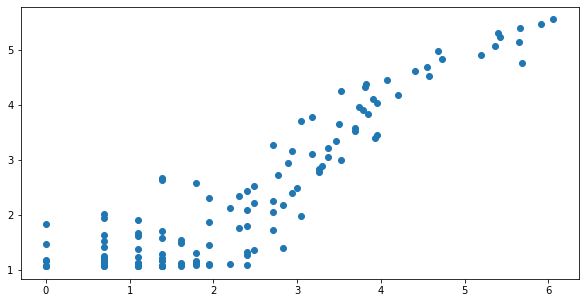

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


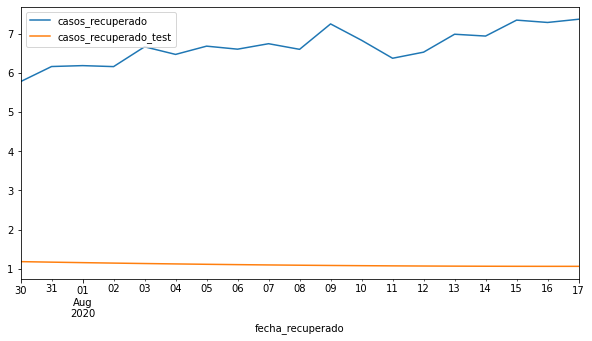

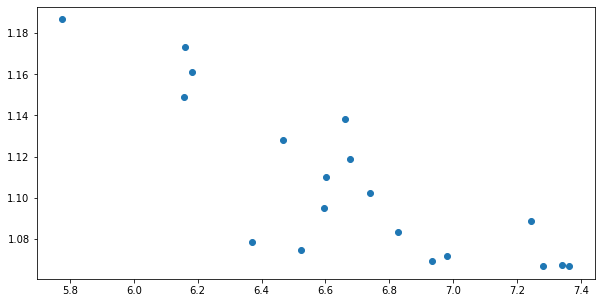

Mean squared error: 0.39
Variance score: 0.82


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1RecuperadoLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1RecuperadoLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=2)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1RecuperadoLogTrain['casos_recuperado'].values.reshape(-1,1))
M1RecuperadoLogTrain['casos_recuperado_fit']=model.predict(x_trainpoly)

plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])
plt.show()

M1RecuperadoLogTest['casos_recuperado_test']=model.predict(x_testpoly)
plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])))

print('Variance score: %.2f' % r2_score(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit']))

#
#Mean squared error: 0.24
#Variance score: 0.94

# LinnearRegression() 

In [ ]:
M1RecuperadoLogTrain['Errores']=M1RecuperadoLogTrain['casos_recuperado']-M1RecuperadoLogTrain['casos_recuperado_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1RecuperadoLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  126
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -109.099
Date:                Tue, 01 Sep 2020   AIC                            224.198
Time:                        02:38:06   BIC                            232.707
Sample:                             0   HQIC                           227.655
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0783      0.072      1.092      0.275      -0.062       0.219
ma.L2          0.4785      0.088      5.464      0.000       0.307       0.650
sigma2         0.3295      0.038      8.765      0.000       0.256       0.403
===================================================================================
Ljung-Box (Q):                       36.10   Jarque-Bera (JB):                 4.31
Prob(Q):                              0.65   Prob(JB):                         0.12
Heteroskedasticity (H):               0.43   Skew:                            -0.39
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


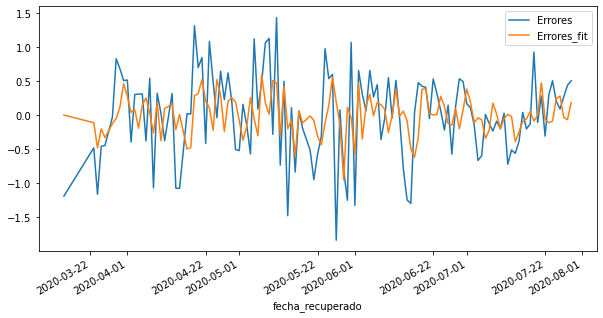

In [ ]:
M1RecuperadoLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1RecuperadoLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


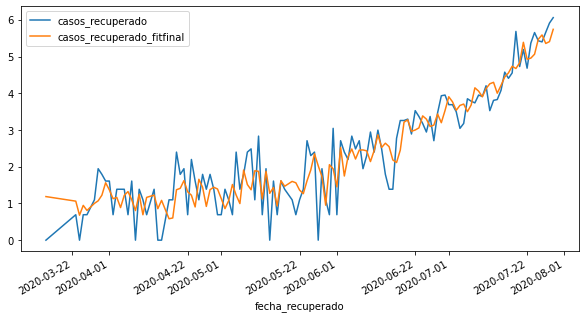

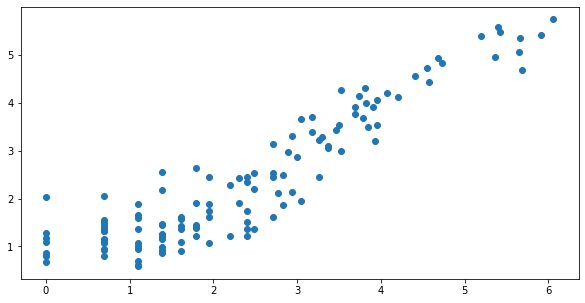

In [ ]:
M1RecuperadoLogTrain['casos_recuperado_fitfinal']=M1RecuperadoLogTrain['casos_recuperado_fit']+M1RecuperadoLogTrain['Errores_fit']
plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


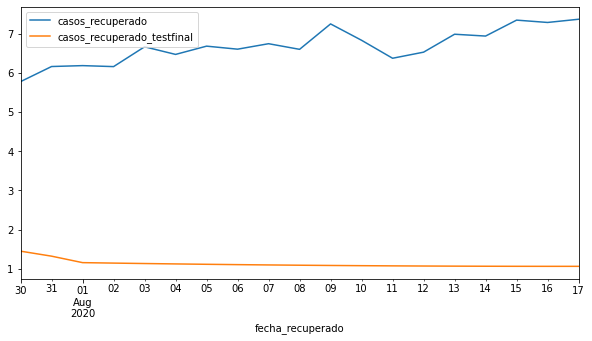

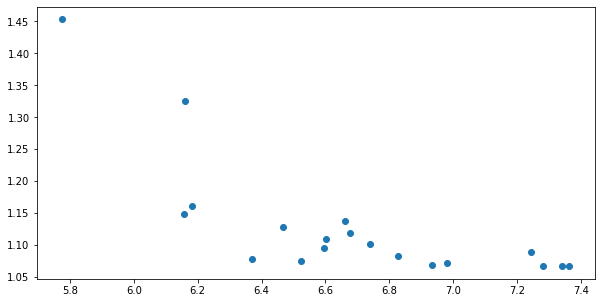

In [ ]:
M1RecuperadoLogTest['Errores_test']=arima.predict(n_periods=(len(M1RecuperadoLogTest)))
M1RecuperadoLogTest['casos_recuperado_testfinal']=M1RecuperadoLogTest['casos_recuperado_test']+M1RecuperadoLogTest['Errores_test']

plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_testfinal'])
plt.show() 

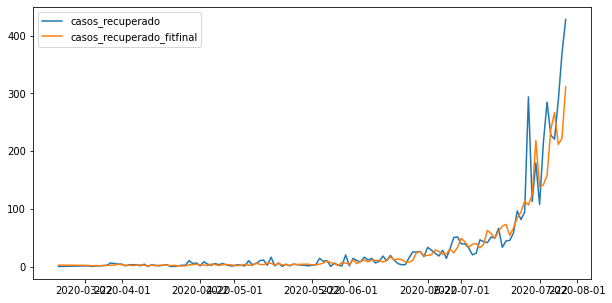

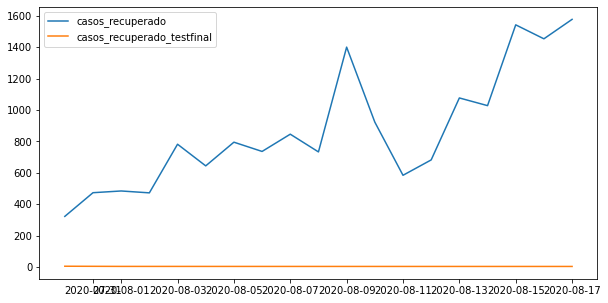

In [ ]:
FM1Recuperado=np.exp(M1RecuperadoLogTrain)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_fitfinal'])
plt.legend(['casos_recuperado','casos_recuperado_fitfinal'])
plt.show()

FM1Recuperado=np.exp(M1RecuperadoLogTest)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_testfinal'])
plt.legend(['casos_recuperado','casos_recuperado_testfinal'])
plt.show()

#x_fore=M1NuevosLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 2: Nuevos RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

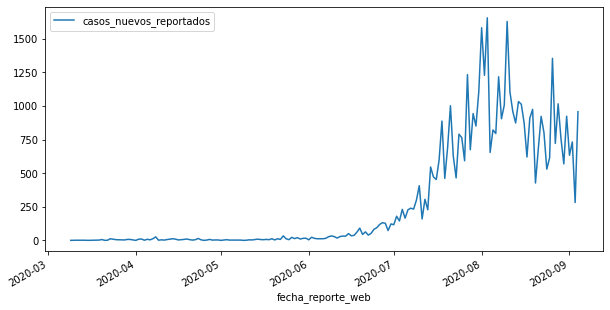

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M2Nuevos=M2Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)
M2Nuevos.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2NuevosTrain=M2Nuevos[:int(len(M2Nuevos)*p_train)]
M2NuevosTest=M2Nuevos[int(len(M2Nuevos)*p_train):int(len(M2Nuevos)*(p_train+p_test))]
M2NuevosForecast=M2Nuevos[int(len(M2Nuevos)*(p_train+p_test)):]
print(M2Nuevos.shape)
print(M2NuevosTrain.shape)
print(M2NuevosTest.shape)
print(M2NuevosForecast.shape)

(170, 1)
(136, 1)
(20, 1)
(14, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2NuevosTrain)

# Creating a data structure with 7 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2NuevosTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(129, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
5/5 [==============================] - 0s 19ms/step - loss: 0.0371
Epoch 2/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0274
Epoch 3/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0189
Epoch 4/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0049
Epoch 5/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0089
Epoch 6/150
5/5 [==============================] - 0s 20ms/step - loss: 0.0098
Epoch 7/150
5/5 [==============================] - 0s 17ms/step - loss: 0.0132
Epoch 8/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0115
Epoch 9/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0094
Epoch 10/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0053
Epoch 11/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0158
Epoch 12/150
5/5 [==============================] - 0s 19ms/step - loss: 0.0191
Epoch 13/150
5/5 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModMedellinNuevos.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Nuevos[:int(len(M2Nuevos)*p_train)]
dataset_test=M2Nuevos[int(len(M2Nuevos)*p_train):int(len(M2Nuevos)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2NuevosTrain['casos_nuevos_reportados_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2NuevosTest['casos_nuevos_reportados_test']=predicted

(20, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


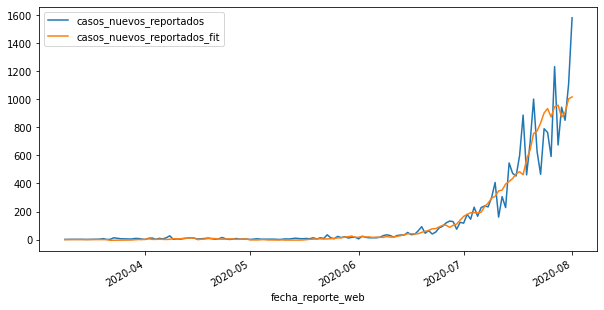

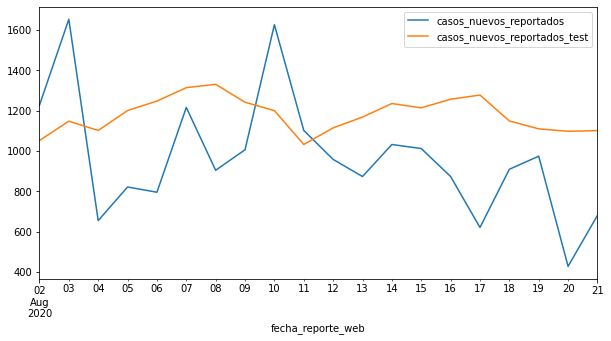

In [ ]:
plot=M2NuevosTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5))
plot=M2NuevosTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2NuevosTrain['casos_nuevos_reportados'],M2NuevosTrain['casos_nuevos_reportados_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2NuevosTest['casos_nuevos_reportados'],M2NuevosTest['casos_nuevos_reportados_test'])
print('MSE in test: %f' % msetest)

MSE in train: 8524.500850
MSE in test: 137380.837525


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


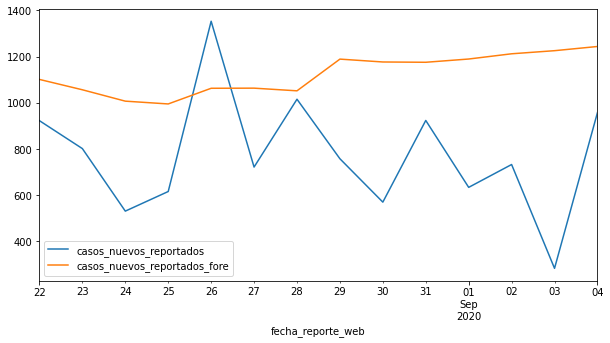

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2NuevosForecast['casos_nuevos_reportados_fore']=fore

plot=M2NuevosForecast[['casos_nuevos_reportados', 'casos_nuevos_reportados_fore']].plot(figsize=(10, 5))

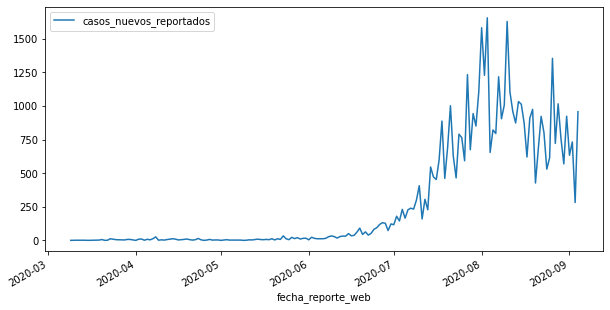

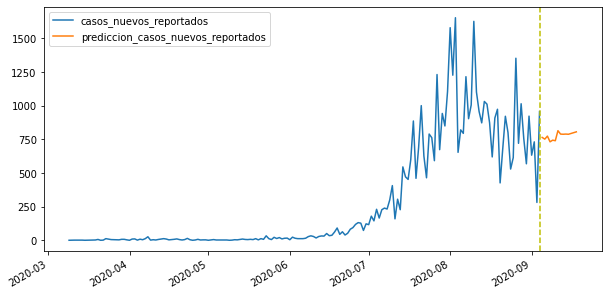

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M2Nuevos=M2Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Nuevos[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

from keras.models import load_model
model = load_model('ModMedellinNuevos.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

MedellinNuevos=sc.inverse_transform(b)

import datetime
index=[M2Nuevos.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
MedellinNuevos=pd.DataFrame(data=MedellinNuevos, index=index, columns=['prediccion_casos_nuevos_reportados'])

M2Nuevos.plot().figure.savefig('images/1.png')

total=pd.concat((M2Nuevos,MedellinNuevos),axis = 0)
total.plot()
plt.axvline(x=M2Nuevos.index[-1],color='y',linestyle='--')
plt.savefig('images/2.png')

MedellinNuevos.to_excel('MedellinNuevos.xlsx')

# Metodología 2: Muerte RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos fallecidos
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muerte'},inplace=True)

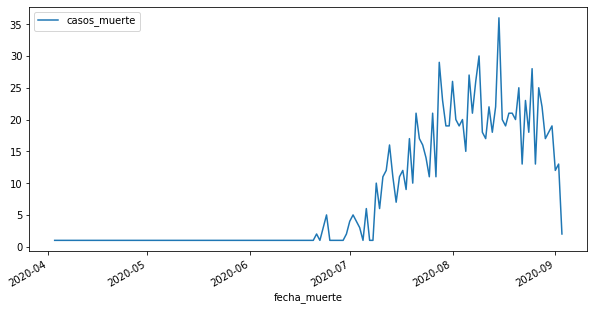

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)
M2Muerte.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2MuerteTrain=M2Muerte[:int(len(M2Muerte)*p_train)]
M2MuerteTest=M2Muerte[int(len(M2Muerte)*p_train):int(len(M2Muerte)*(p_train+p_test))]
M2MuerteForecast=M2Muerte[int(len(M2Muerte)*(p_train+p_test)):]
print(M2Muerte.shape)
print(M2MuerteTrain.shape)
print(M2MuerteTest.shape)
print(M2MuerteForecast.shape)

(79, 1)
(63, 1)
(9, 1)
(7, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2MuerteTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2MuerteTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(56, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
2/2 [==============================] - 0s 18ms/step - loss: 0.1895
Epoch 2/150
2/2 [==============================] - 0s 13ms/step - loss: 0.1508
Epoch 3/150
2/2 [==============================] - 0s 13ms/step - loss: 0.1016
Epoch 4/150
2/2 [==============================] - 0s 13ms/step - loss: 0.0460
Epoch 5/150
2/2 [==============================] - 0s 13ms/step - loss: 0.0547
Epoch 6/150
2/2 [==============================] - 0s 14ms/step - loss: 0.0533
Epoch 7/150
2/2 [==============================] - 0s 12ms/step - loss: 0.0297
Epoch 8/150
2/2 [==============================] - 0s 12ms/step - loss: 0.0351
Epoch 9/150
2/2 [==============================] - 0s 13ms/step - loss: 0.0415
Epoch 10/150
2/2 [==============================] - 0s 13ms/step - loss: 0.0397
Epoch 11/150
2/2 [==============================] - 0s 13ms/step - loss: 0.0322
Epoch 12/150
2/2 [==============================] - 0s 16ms/step - loss: 0.0246
Epoch 13/150
2/2 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModMedellinMuerte.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Muerte[:int(len(M2Muerte)*p_train)]
dataset_test=M2Muerte[int(len(M2Muerte)*p_train):int(len(M2Muerte)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2MuerteTrain['casos_muerte_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2MuerteTest['casos_muerte_test']=predicted

(9, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


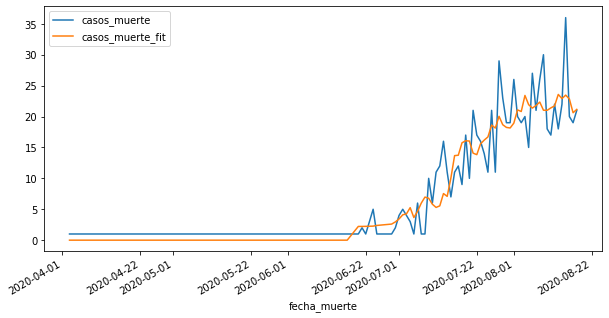

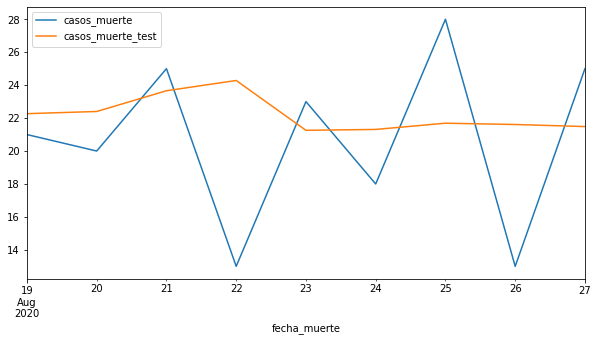

In [ ]:
plot=M2MuerteTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))
plot=M2MuerteTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2MuerteTrain['casos_muerte'],M2MuerteTrain['casos_muerte_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2MuerteTest['casos_muerte'],M2MuerteTest['casos_muerte_test'])
print('MSE in test: %f' % msetest)

MSE in train: 17.327705
MSE in test: 31.250393


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


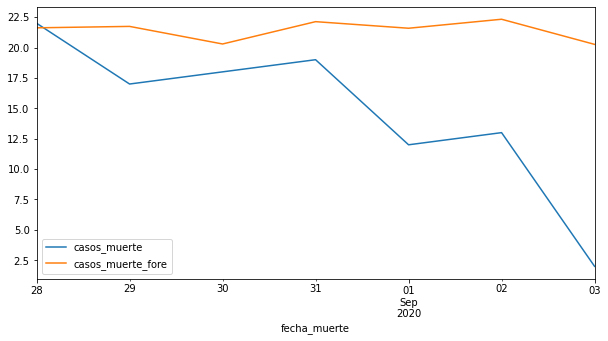

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,8):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2MuerteForecast['casos_muerte_fore']=fore

plot=M2MuerteForecast[['casos_muerte', 'casos_muerte_fore']].plot(figsize=(10, 5))

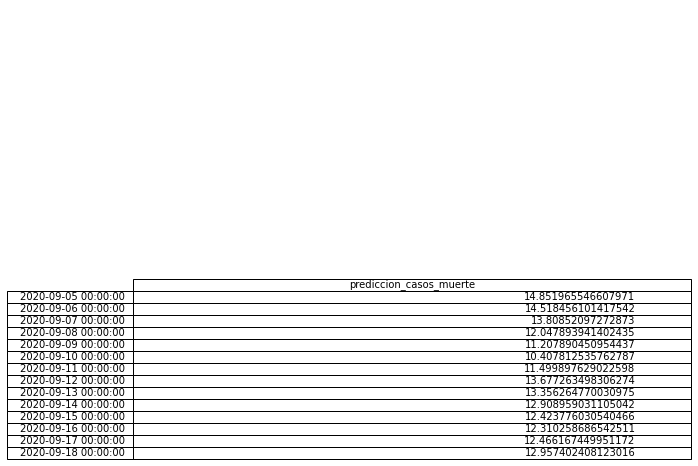

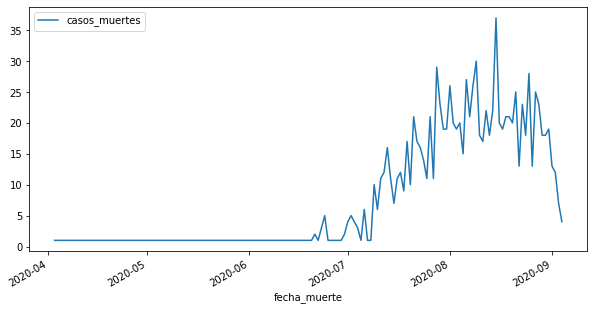

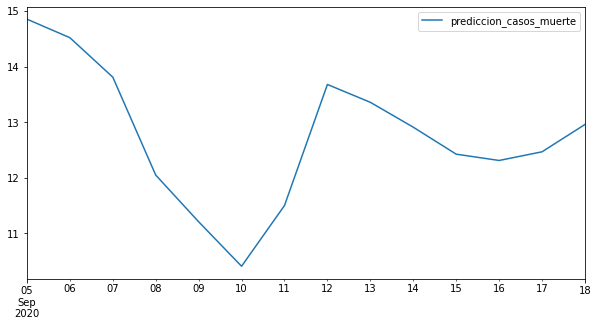

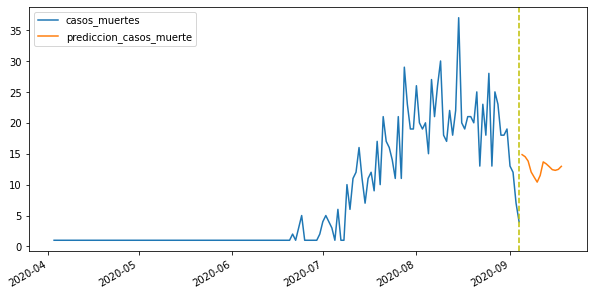

In [ ]:
# tabla con ciudades filtradas para modelar casos muerte
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muertes'},inplace=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Muerte[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

model = load_model('ModMedellinMuerte.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

MedellinMuerte=sc.inverse_transform(b)

import datetime
index=[M2Muerte.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
MedellinMuerte=pd.DataFrame(data=MedellinMuerte, index=index, columns=['prediccion_casos_muerte'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, MedellinMuerte) 
plt.savefig('images/7.png')

M2Muerte.plot().figure.savefig('images/5.png')

MedellinMuerte.plot().figure.savefig('images/6.png')

total=pd.concat((M2Muerte,MedellinMuerte),axis = 0)
total.plot()
plt.axvline(x=M2Muerte.index[-1],color='y',linestyle='--')
plt.savefig('images/8.png')

MedellinMuerte.to_excel('MedellinMuerte.xlsx')

# Metodología 2: Recuperados RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperados
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

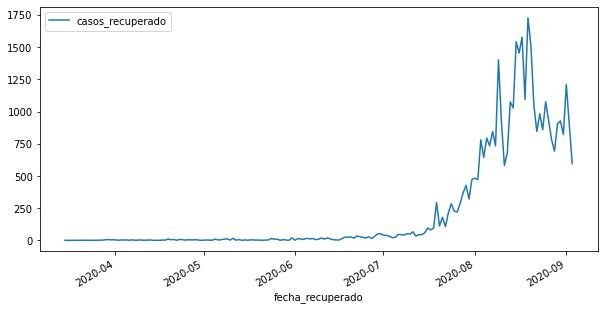

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)
M2Recuperado.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2RecuperadoTrain=M2Recuperado[:int(len(M2Recuperado)*p_train)]
M2RecuperadoTest=M2Recuperado[int(len(M2Recuperado)*p_train):int(len(M2Recuperado)*(p_train+p_test))]
M2RecuperadoForecast=M2Recuperado[int(len(M2Recuperado)*(p_train+p_test)):]
print(M2Recuperado.shape)
print(M2RecuperadoTrain.shape)
print(M2RecuperadoTest.shape)
print(M2RecuperadoForecast.shape)

(162, 1)
(129, 1)
(20, 1)
(13, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2RecuperadoTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2RecuperadoTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(122, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0443
Epoch 2/150
4/4 [==============================] - 0s 24ms/step - loss: 0.0343
Epoch 3/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0327
Epoch 4/150
4/4 [==============================] - 0s 22ms/step - loss: 0.0197
Epoch 5/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0097
Epoch 6/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0064
Epoch 7/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0058
Epoch 8/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0053
Epoch 9/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0044
Epoch 10/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0042
Epoch 11/150
4/4 [==============================] - 0s 22ms/step - loss: 0.0041
Epoch 12/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0041
Epoch 13/150
4/4 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModMedellinRecuperado.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Recuperado[:int(len(M2Recuperado)*p_train)]
dataset_test=M2Recuperado[int(len(M2Recuperado)*p_train):int(len(M2Recuperado)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2RecuperadoTrain['casos_recuperado_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2RecuperadoTest['casos_recuperado_test']=predicted

(20, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


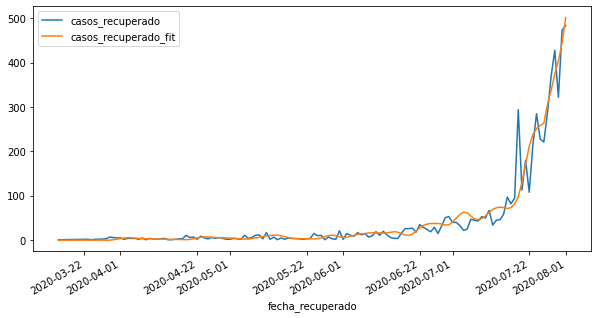

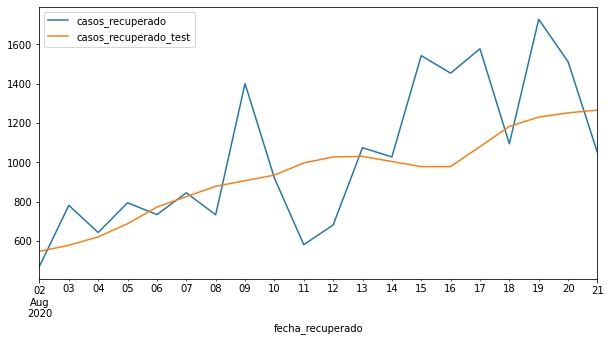

In [ ]:
plot=M2RecuperadoTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))
plot=M2RecuperadoTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2RecuperadoTrain['casos_recuperado'],M2RecuperadoTrain['casos_recuperado_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2RecuperadoTest['casos_recuperado'],M2RecuperadoTest['casos_recuperado_test'])
print('MSE in test: %f' % msetest)

MSE in train: 610.137334
MSE in test: 89076.805946


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


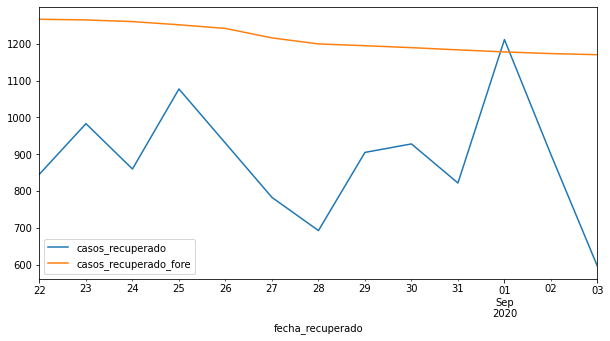

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,14):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2RecuperadoForecast['casos_recuperado_fore']=fore

plot=M2RecuperadoForecast[['casos_recuperado', 'casos_recuperado_fore']].plot(figsize=(10, 5))

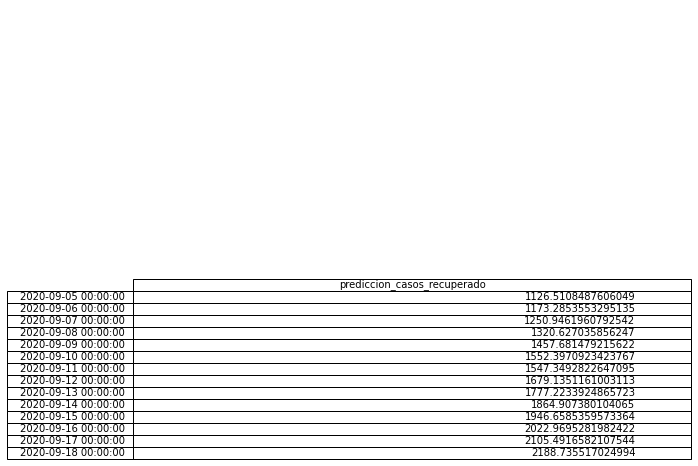

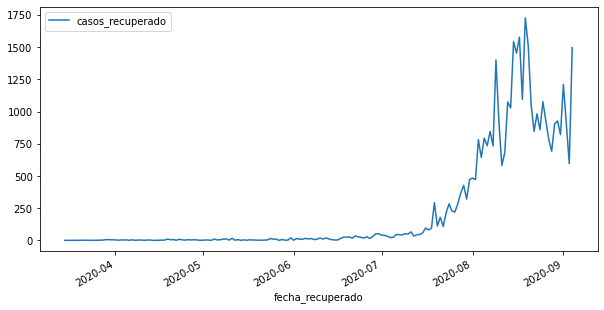

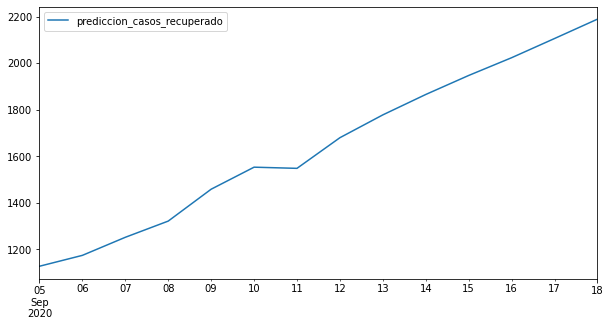

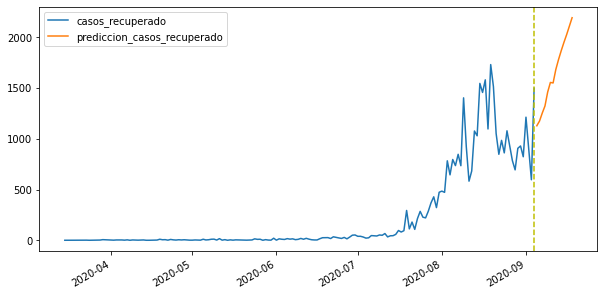

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperado
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Recuperado[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

model = load_model('ModMedellinRecuperado.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

MedellinRecuperado=sc.inverse_transform(b)

import datetime
index=[M2Recuperado.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
MedellinRecuperado=pd.DataFrame(data=MedellinRecuperado, index=index, columns=['prediccion_casos_recuperado'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, MedellinRecuperado) 
plt.savefig('images/11.png')

M2Recuperado.plot().figure.savefig('images/9.png')

MedellinRecuperado.plot().figure.savefig('images/10.png')

total=pd.concat((M2Recuperado,MedellinRecuperado),axis = 0)
total.plot()
plt.axvline(x=M2Recuperado.index[-1],color='y',linestyle='--')
plt.savefig('images/12.png')